In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os
from tqdm import tqdm
import json
import random
import pandas as pd
import seaborn as sns
import yaml
from collections import OrderedDict, Counter
import datasets
from datasets import load_dataset

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from keras import backend as K
from keras.layers import Dense
from keras.models import Model

from scipy.io.wavfile import read as wav_read
from scipy.io.wavfile import write as wav_write
import scipy.signal as sps
import soundfile as sf
from scipy.io import wavfile
from IPython.display import Javascript, HTML, Audio
import pyaudio

lg_pred = {0:'Other', 1:'JP'}
shape_sample = 80000

In [2]:
def normalize(signal):
    maximum = max(abs(signal.max()), abs(signal.min()))
    if maximum == 0.0:
        print("normalize: omitting to divide by zero!!")
        return signal
    return signal / float(maximum)
 
def pad_or_cut(data, max_len):
    if len(data) == max_len:
        return data
    elif len(data) > max_len:
        return data[:max_len]
    else:
        to_add = max(max_len - len(data), 0)
        data = np.pad(data, (0, to_add), mode='constant', constant_values=0)
        return data
    
def process_batch(audio, shape_sample):
    for idx, x in tqdm(enumerate(audio)):
        x = normalize(x)
        x = pad_or_cut(x, shape_sample)
        audio[idx,:] = x
    return audio
    
def recall_m(y_true, y_pred):
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return TP / (Positives+K.epsilon())
    
def precision_m(y_true, y_pred):
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return TP / (Pred_Positives+K.epsilon()) 

def f1_score_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def plot_cm_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title+'\naccuracy={:0.3f}; misclass={:0.3f}'.format(accuracy, misclass))
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)
        
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_cm_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title+'\naccuracy={:0.3f}; misclass={:0.3f}'.format(accuracy, misclass))
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)
        
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Dataset creation

## Japanese speech

In [3]:
data_dir_jp = '../data/kokoro-speech-v1_3-sample-flac/wavs'
list_path_jp = [os.path.join(data_dir_jp, i) for i in os.listdir(data_dir_jp)][:500]

X = np.zeros((1,))
for path in tqdm(list_path_jp):
    data, sr = sf.read(path)
    X = np.hstack((X, data))
X = X[1:]
print(X.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:41<00:00, 11.97it/s]

(56176640,)


In [4]:
batch_size = len(X) // shape_sample
X = X[:batch_size * shape_sample].reshape(batch_size, shape_sample)
print(X.shape)

(702, 80000)


In [5]:
idx = 0
Audio(X[idx], rate=sr, normalize=False)

In [6]:
X_jp = process_batch(X, shape_sample)
y_jp = np.ones(X_jp.shape[0])

print(X_jp.shape, y_jp.shape)

702it [00:00, 3924.22it/s]

(702, 80000) (702,)


## Other speech

In [7]:
fr = iter(load_dataset("facebook/multilingual_librispeech", "french", split="validation", streaming=True))
ger = iter(load_dataset("facebook/multilingual_librispeech", "german", split="validation", streaming=True))
pol = iter(load_dataset("facebook/multilingual_librispeech", "polish", split="validation", streaming=True))
du = iter(load_dataset("facebook/multilingual_librispeech", "dutch", split="validation", streaming=True))
spa = iter(load_dataset("facebook/multilingual_librispeech", "spanish", split="validation", streaming=True))
ita = iter(load_dataset("facebook/multilingual_librispeech", "italian", split="validation", streaming=True))
por = iter(load_dataset("facebook/multilingual_librispeech", "portuguese", split="validation", streaming=True))

iterator_dict = {'fr':fr,'ger':ger,'pol':pol,'du':du,'spa':spa,'ita':ita,'por':por}
iterator_dict_matching = {k:idx for idx, k in enumerate(iterator_dict.keys())}
iterator_dict_matching_reverse = {idx: k for idx, k in enumerate(iterator_dict.keys())}
fr, ger, pol, du, spa, ita, por = None, None, None, None, None, None, None

In [8]:
X, lbl = [], []
jp_len = len(y_jp)

for lg, iterator in iterator_dict.items():
    for idx, sample in enumerate(tqdm(iterator)):
        x = sample['audio']['array']
        sr = sample['audio']['sampling_rate']
        X.append(list(x))
        lbl.append([iterator_dict_matching[lg] for i in range(len(x))])
        if idx >= int(jp_len/len(iterator_dict)):
            break 

X = np.array([i for s in X for i in s])
lbl = np.array([i for s in lbl for i in s])

batch_size = len(X) // shape_sample
X = X[:batch_size * shape_sample].reshape(batch_size, shape_sample)
lbl = lbl[:batch_size * shape_sample].reshape(batch_size, shape_sample)

mask = np.array([len(set(row)) == 1 for row in lbl]) # Remove multiple language in one batch
X, lbl = X[mask,:], lbl[mask,0]

X, _, lbl, _ = train_test_split(X, lbl, train_size=len(X_jp)/len(X), random_state=42, stratify=lbl)
print(X.shape, lbl.shape)

100it [00:17,  5.77it/s]
100it [00:13,  7.40it/s]
100it [00:12,  8.09it/s]
100it [00:12,  8.30it/s]
100it [00:15,  6.45it/s]
100it [00:13,  7.32it/s]
100it [00:17,  5.65it/s]


(702, 80000) (702,)


In [9]:
idx = 10
print(iterator_dict_matching_reverse[lbl[idx]])
Audio(X[idx], rate=sr, normalize=True)

ger


In [10]:
X_other = process_batch(X, shape_sample)
y_other = np.zeros(X_other.shape[0])

print(X_other.shape, y_other.shape)

702it [00:00, 5098.53it/s]

(702, 80000) (702,)


## Data gathering

In [11]:
X = np.vstack((X_jp, X_other))
y = np.hstack((y_jp, y_other))

print(X.shape, y.shape)

(1404, 80000) (1404,)


## Data visualization

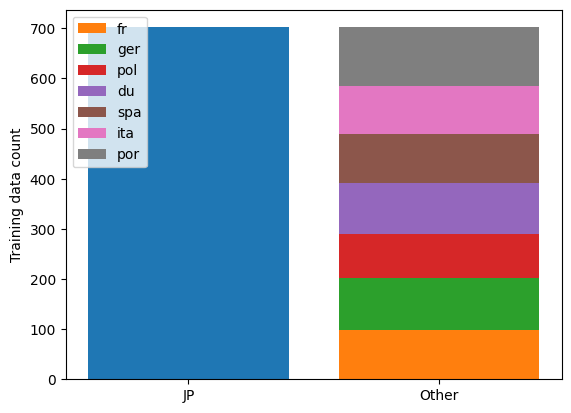

In [12]:
fig, ax = plt.subplots()
ax.bar('JP', len(X_jp))

categories = ['Other']
sorted_dict = OrderedDict(sorted(Counter(lbl).items()))
stack_values = np.array([list(sorted_dict.values())])

bottom = np.zeros(len(categories))
for i in range(stack_values.shape[1]):
    ax.bar(categories, stack_values[:, i], bottom=bottom, label=f'{iterator_dict_matching_reverse[i]}')
    bottom += stack_values[:, i]

ax.set_ylabel('Training data count')
plt.legend()
plt.show()

In [13]:
iterator_dict, X_jp, X_other, y_jp, y_other = None, None, None, None, None

In [14]:
print(X.shape, y.shape)
X_train, X, y_train, y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(1404, 80000) (1404,)
(1123, 80000, 1) (1123, 2) (140, 80000, 1) (140, 2) (141, 80000, 1) (141, 2)


In [15]:
X, y = None, None

# Model training

In [17]:
model_path = '../model/model_17'

In [18]:
model = load_model(model_path)
x = model.layers[-2].output
output = Dense(2, activation='softmax', name='final')(x)
net = Model(inputs=model.input, outputs=output)

metrics = [precision_m, recall_m, f1_score_m]
net.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

In [19]:
model = None

In [20]:
callbacks_list = [EarlyStopping(monitor='val_loss', patience=10),
                  EarlyStopping(monitor='val_f1_score_m', patience=10, mode='max', baseline=1.0),
                  ModelCheckpoint(filepath='../model/model.{epoch:02d}-{val_loss:.2f}.h5', save_best_only=True, monitor='val_loss', mode='min'),
                  ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)]

In [ ]:
history = net.fit(X_train,
                  y_train,
                  epochs=50,
                  batch_size=80000,
                  callbacks=callbacks_list,
                  validation_data=(X_val, y_val),
                  shuffle=True,
                  verbose=1)

Epoch 1/50



In [ ]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 15})

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['f1_score_m'], label='train_f1_score')
plt.plot(history.history['val_f1_score_m'], label='val_f1_score')
plt.legend()

plt.tight_layout()

In [ ]:
preds = net.predict(X_test)

In [ ]:
print(classification_report(y_test.argmax(axis=1),
                            preds.argmax(axis=1),
                            target_names=lg_pred.values()))

In [ ]:
res = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(preds, axis=1))
confusion = pd.DataFrame(res, columns=lg_pred.values(), index = lg_pred.values())
confusion.index.name, confusion.columns.name = 'Actual', 'Predicted'

plt.figure(figsize = (10,4))
sns.set(font_scale=1)
sns.heatmap(confusion, annot=True, cmap='Blues', annot_kws={"size": 10})
plt.show()

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = None, None, None, None, None, None

In [ ]:
sys.exit()

# Evaluation on unknow data

In [ ]:
# https://huggingface.co/datasets/google/fleurs
eval_jp = iter(load_dataset("google/fleurs", "ja_jp", split="validation", streaming=True))

In [ ]:
X_jp, lbl_jp = [], []

for idx, sample in enumerate(tqdm(eval_jp)):
    x = sample['audio']['array']
    sr = sample['audio']['sampling_rate']
    X_jp.append(list(x))
    lbl_jp.append([1 for i in range(len(x))])

X_jp = np.array([i for s in X_jp for i in s])
lbl_jp = np.array([i for s in lbl_jp for i in s])

batch_size = len(X_jp) // shape_sample
X_jp = X_jp[:batch_size * shape_sample].reshape(batch_size, shape_sample)
lbl_jp = lbl_jp[:batch_size * shape_sample].reshape(batch_size, shape_sample)

print(X_jp.shape, lbl_jp.shape)

In [ ]:
idx = 10
Audio(X_jp[idx], rate=sr, normalize=True)

In [ ]:
X_jp = process_batch(X_jp, shape_sample)
y_jp = np.zeros(X_jp.shape[0])

print(X_jp.shape, y_jp.shape)

In [ ]:
_FLEURS_LANG_TO_ID = OrderedDict([("Afrikaans", "af"), ("Amharic", "am"), ("Arabic", "ar"), ("Armenian", "hy"), ("Assamese", "as"), ("Asturian", "ast"), ("Azerbaijani", "az"), ("Belarusian", "be"), ("Bengali", "bn"), ("Bosnian", "bs"), ("Bulgarian", "bg"), ("Burmese", "my"), ("Catalan", "ca"), ("Cebuano", "ceb"), ("Mandarin Chinese", "cmn_hans"), ("Cantonese Chinese", "yue_hant"), ("Croatian", "hr"), ("Czech", "cs"), ("Danish", "da"), ("Dutch", "nl"), ("English", "en"), ("Estonian", "et"), ("Filipino", "fil"), ("Finnish", "fi"), ("French", "fr"), ("Fula", "ff"), ("Galician", "gl"), ("Ganda", "lg"), ("Georgian", "ka"), ("German", "de"), ("Greek", "el"), ("Gujarati", "gu"), ("Hausa", "ha"), ("Hebrew", "he"), ("Hindi", "hi"), ("Hungarian", "hu"), ("Icelandic", "is"), ("Igbo", "ig"), ("Indonesian", "id"), ("Irish", "ga"), ("Italian", "it"), ("Japanese", "ja"), ("Javanese", "jv"), ("Kabuverdianu", "kea"), ("Kamba", "kam"), ("Kannada", "kn"), ("Kazakh", "kk"), ("Khmer", "km"), ("Korean", "ko"), ("Kyrgyz", "ky"), ("Lao", "lo"), ("Latvian", "lv"), ("Lingala", "ln"), ("Lithuanian", "lt"), ("Luo", "luo"), ("Luxembourgish", "lb"), ("Macedonian", "mk"), ("Malay", "ms"), ("Malayalam", "ml"), ("Maltese", "mt"), ("Maori", "mi"), ("Marathi", "mr"), ("Mongolian", "mn"), ("Nepali", "ne"), ("Northern-Sotho", "nso"), ("Norwegian", "nb"), ("Nyanja", "ny"), ("Occitan", "oc"), ("Oriya", "or"), ("Oromo", "om"), ("Pashto", "ps"), ("Persian", "fa"), ("Polish", "pl"), ("Portuguese", "pt"), ("Punjabi", "pa"), ("Romanian", "ro"), ("Russian", "ru"), ("Serbian", "sr"), ("Shona", "sn"), ("Sindhi", "sd"), ("Slovak", "sk"), ("Slovenian", "sl"), ("Somali", "so"), ("Sorani-Kurdish", "ckb"), ("Spanish", "es"), ("Swahili", "sw"), ("Swedish", "sv"), ("Tajik", "tg"), ("Tamil", "ta"), ("Telugu", "te"), ("Thai", "th"), ("Turkish", "tr"), ("Ukrainian", "uk"), ("Umbundu", "umb"), ("Urdu", "ur"), ("Uzbek", "uz"), ("Vietnamese", "vi"), ("Welsh", "cy"), ("Wolof", "wo"), ("Xhosa", "xh"), ("Yoruba", "yo"), ("Zulu", "zu")])
_FLEURS_LANG_SHORT_TO_LONG = {v: k for k, v in _FLEURS_LANG_TO_ID.items()}

_FLEURS_LANG = sorted(["af_za", "am_et", "ar_eg", "as_in", "ast_es", "az_az", "be_by", "bn_in", "bs_ba", "ca_es", "ceb_ph", "cmn_hans_cn", "yue_hant_hk", "cs_cz", "cy_gb", "da_dk", "de_de", "el_gr", "en_us", "es_419", "et_ee", "fa_ir", "ff_sn", "fi_fi", "fil_ph", "fr_fr", "ga_ie", "gl_es", "gu_in", "ha_ng", "he_il", "hi_in", "hr_hr", "hu_hu", "hy_am", "id_id", "ig_ng", "is_is", "it_it", "ja_jp", "jv_id", "ka_ge", "kam_ke", "kea_cv", "kk_kz", "km_kh", "kn_in", "ko_kr", "ckb_iq", "ky_kg", "lb_lu", "lg_ug", "ln_cd", "lo_la", "lt_lt", "luo_ke", "lv_lv", "mi_nz", "mk_mk", "ml_in", "mn_mn", "mr_in", "ms_my", "mt_mt", "my_mm", "nb_no", "ne_np", "nl_nl", "nso_za", "ny_mw", "oc_fr", "om_et", "or_in", "pa_in", "pl_pl", "ps_af", "pt_br", "ro_ro", "ru_ru", "bg_bg", "sd_in", "sk_sk", "sl_si", "sn_zw", "so_so", "sr_rs", "sv_se", "sw_ke", "ta_in", "te_in", "tg_tj", "th_th", "tr_tr", "uk_ua", "umb_ao", "ur_pk", "uz_uz", "vi_vn", "wo_sn", "xh_za", "yo_ng", "zu_za"])
_FLEURS_LONG_TO_LANG = {_FLEURS_LANG_SHORT_TO_LONG["_".join(k.split("_")[:-1]) or k]: k for k in _FLEURS_LANG}
_FLEURS_LANG_TO_LONG = {v: k for k, v in _FLEURS_LONG_TO_LANG.items()}

_FLEURS_GROUP_TO_LONG = OrderedDict({
    "western_european_we": ["Asturian", "Bosnian", "Catalan", "Croatian", "Danish", "Dutch", "English", "Finnish", "French", "Galician", "German", "Greek", "Hungarian", "Icelandic", "Irish", "Italian", "Kabuverdianu", "Luxembourgish", "Maltese", "Norwegian", "Occitan", "Portuguese", "Spanish", "Swedish", "Welsh"],
    "eastern_european_ee": ["Armenian", "Belarusian", "Bulgarian", "Czech", "Estonian", "Georgian", "Latvian", "Lithuanian", "Macedonian", "Polish", "Romanian", "Russian", "Serbian", "Slovak", "Slovenian", "Ukrainian"],
    "central_asia_middle_north_african_cmn": ["Arabic", "Azerbaijani", "Hebrew", "Kazakh", "Kyrgyz", "Mongolian", "Pashto", "Persian", "Sorani-Kurdish", "Tajik", "Turkish", "Uzbek"],
    "sub_saharan_african_ssa": ["Afrikaans", "Amharic", "Fula", "Ganda", "Hausa", "Igbo", "Kamba", "Lingala", "Luo", "Northern-Sotho", "Nyanja", "Oromo", "Shona", "Somali", "Swahili", "Umbundu", "Wolof", "Xhosa", "Yoruba", "Zulu"],
    "south_asian_sa": ["Assamese", "Bengali", "Gujarati", "Hindi", "Kannada", "Malayalam", "Marathi", "Nepali", "Oriya", "Punjabi", "Sindhi", "Tamil", "Telugu", "Urdu"],
    "south_east_asian_sea": ["Burmese", "Cebuano", "Filipino", "Indonesian", "Javanese", "Khmer", "Lao", "Malay", "Maori", "Thai", "Vietnamese"],
    "chinese_japanase_korean_cjk": ["Mandarin Chinese", "Cantonese Chinese", "Japanese", "Korean"],
})
_FLEURS_LONG_TO_GROUP = {a: k for k, v in _FLEURS_GROUP_TO_LONG.items() for a in v}
_FLEURS_LANG_TO_GROUP = {_FLEURS_LONG_TO_LANG[k]: v for k, v in _FLEURS_LONG_TO_GROUP.items()}
_FLEURS_LANG_TO_LONG

In [ ]:
arabic = iter(load_dataset("google/fleurs", "ar_eg", split="validation", streaming=True))
afrikaans = iter(load_dataset("google/fleurs", "af_za", split="validation", streaming=True))
mandarin = iter(load_dataset("google/fleurs", "cmn_hans_cn", split="validation", streaming=True))
khmer = iter(load_dataset("google/fleurs", "km_kh", split="validation", streaming=True))
vietnamese = iter(load_dataset("google/fleurs", "vi_vn", split="validation", streaming=True))
norwegian = iter(load_dataset("google/fleurs", "nb_no", split="validation", streaming=True))
cantonese = iter(load_dataset("google/fleurs", "yue_hant_hk", split="validation", streaming=True))
korean = iter(load_dataset("google/fleurs", "ko_kr", split="validation", streaming=True))
filipino = iter(load_dataset("google/fleurs", "fil_ph", split="validation", streaming=True))
hindi = iter(load_dataset("google/fleurs", "'hi_in'", split="validation", streaming=True))

iterator_dict = {'arabic':arabic, 'afrikaans':afrikaans, 'mandarin':mandarin, 'khmer':khmer, 'vietnamese':vietnamese, 'norwegian':norwegian, 'cantonese':cantonese, 'korean':korean, 'filipino':filipino, 'hindi':hindi}
iterator_dict_matching = {k:idx for idx, k in enumerate(iterator_dict.keys())}
iterator_dict_matching_reverse = {idx: k for idx, k in enumerate(iterator_dict.keys())}
arabic, afrikaans, mandarin, khmer, vietnamese, norwegian, cantonese = None, None, None, None, None, None, None

In [ ]:
X, lbl = [], []
jp_len = len(y_jp)

for lg, iterator in iterator_dict.items():
    for idx, sample in enumerate(tqdm(iterator)):
        x = sample['audio']['array']
        sr = sample['audio']['sampling_rate']
        X.append(list(x))
        lbl.append([iterator_dict_matching[lg] for i in range(len(x))])
        if idx >= int(jp_len/len(iterator_dict)):
            break 

X = np.array([i for s in X for i in s])
lbl = np.array([i for s in lbl for i in s])

batch_size = len(X) // shape_sample
X = X[:batch_size * shape_sample].reshape(batch_size, shape_sample)
lbl = lbl[:batch_size * shape_sample].reshape(batch_size, shape_sample)

mask = np.array([len(set(row)) == 1 for row in lbl]) # Remove multiple language in one batch
X, lbl = X[mask,:], lbl[mask,0]

X, _, lbl, _ = train_test_split(X, lbl, train_size=len(X_jp)/len(X), random_state=42, stratify=lbl)
print(X.shape, lbl.shape)

In [ ]:
idx = 10
print(iterator_dict_matching_reverse[lbl[idx]])
Audio(X[idx], rate=sr, normalize=True)

In [ ]:
X_other = process_batch(X, shape_sample)
y_other = np.zeros(X_other.shape[0])

print(X_other.shape, y_other.shape)

In [ ]:
X = np.vstack((X_jp, X_other))
y = np.hstack((y_jp, y_other))

print(X.shape, y.shape)

In [ ]:
fig, ax = plt.subplots()
ax.bar('JP', len(X_jp))

categories = ['Other']
sorted_dict = OrderedDict(sorted(Counter(lbl).items()))
stack_values = np.array([list(sorted_dict.values())])

bottom = np.zeros(len(categories))
for i in range(stack_values.shape[1]):
    ax.bar(categories, stack_values[:, i], bottom=bottom, label=f'{iterator_dict_matching_reverse[i]}')
    bottom += stack_values[:, i]

ax.set_ylabel('Training data count')
plt.legend()
plt.show()

In [ ]:
preds_eval = net.predict(np.expand_dims(X, axis=-1))

In [ ]:
lbl_to_binary = [0 if lg_dict[i]!='japanese' else 1 for i in lbl]
print(classification_report(lbl_to_binary,
                            preds_eval.argmax(axis=1),
                            target_names=lg_pred.values()))

In [ ]:
plt.figure(figsize=(10,5))
sns.set(font_scale=1)
sns.set_style("white")
sns.set_style("ticks")
cm = confusion_matrix(lbl_to_binary, np.argmax(preds_eval, axis=1))
plot_cm_matrix(cm, lg_pred.values(),'Confusion matrix')
plt.show()